In [1]:
import torch
from null_text_inversion import NullInversion
from diffusers import StableDiffusionPipeline, DDIMScheduler

scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
MY_TOKEN = ''
LOW_RESOURCE = False 
NUM_DDIM_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
ldm_stable = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-base", use_auth_token=MY_TOKEN, scheduler=scheduler).to(device)
try:
    ldm_stable.disable_xformers_memory_efficient_attention()
except AttributeError:
    print("Attribute disable_xformers_memory_efficient_attention() is missing")
tokenizer = ldm_stable.tokenizer

Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

/home/zhaowei/anaconda3/lib/python3.10/site-packages/diffusers/utils/deprecation_utils.py:35: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.9.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "steps_offset": 0,
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would be very nice if you could open a Pull request for the `scheduler/scheduler_config.json` file
  warnings.warn(warning + message, FutureWarning)


In [2]:
null_inversion = NullInversion(ldm_stable,NUM_DDIM_STEPS,GUIDANCE_SCALE)


In [3]:
import numpy as np
image_path = "cat.jpeg"
prompt = "cat"
(image_gt, image_enc), x_t, uncond_embeddings = null_inversion.invert(image_path, prompt, offsets=(0,0,200,0), verbose=True)

print("Modify or remove offsets according to your image!")


DDIM inversion...
Null-text optimization...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:01<00:00,  1.66it/s]

Modify or remove offsets according to your image!


In [5]:
import torch
from attention_control import AttentionStore,run_and_display,show_cross_attention


#First let's generate an image and visualize the cross-attention maps for each word in the prompt. Notice, we normalize each map to 0-1.
#Cross-Attention Visualization
g_cpu = torch.Generator().manual_seed(8888) 
prompts = ["cat"]
controller = AttentionStore()
image, x_t = run_and_display(prompts, controller, num_diffusion_steps = 50,guidance_scale=7.5, ldm_stable=ldm_stable,latent=x_t, run_baseline=False, generator=g_cpu,uncond_embeddings=uncond_embeddings )
show_cross_attention(prompts,controller, res=16, from_where=("up", "down"),)







  0%|          | 0/50 [00:00<?, ?it/s]

In [6]:
from ptp_utils import view_images
view_images(image)

In [7]:
from typing import Optional, Union, Tuple, List, Dict
from attention_control import *


prompts = ["cat",
           "tiger"
        ]
cross_replace_steps = {'default_': .8,}
self_replace_steps = .5
blend_word = ((('cat',), ("tiger",))) # for local edit. If it is not local yet - use only the source object: blend_word = ((('cat',), ("cat",))).
eq_params = {"words": ("tiger",), "values": (2,)} # amplify attention to the word "tiger" by *2 

controller = make_controller(prompts, True, cross_replace_steps, self_replace_steps, blend_word, eq_params,num_ddim_steps=50,tokenizer=tokenizer)
images, _ = run_and_display(prompts, controller, run_baseline=False, latent=x_t, uncond_embeddings=uncond_embeddings,ldm_stable=ldm_stable)
view_images(images)

  0%|          | 0/50 [00:00<?, ?it/s]

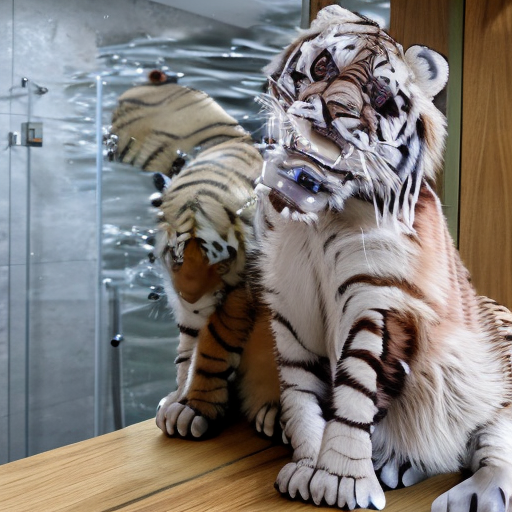

In [9]:
img = images[1]
img = Image.fromarray(img)
img

In [62]:
import torch
from attention_control import AttentionStore,run_and_display,show_cross_attention,MaskPeturb


#First let's generate an image and visualize the cross-attention maps for each word in the prompt. Notice, we normalize each map to 0-1.
#Cross-Attention Visualization
g_cpu = torch.Generator().manual_seed(8888) 
prompts = ["shark",]
blend_word =  ["shark",'cat']
controller = AttentionStore()
image, x_t = run_and_display(prompts, controller, num_diffusion_steps = 50,guidance_scale=7.5, ldm_stable=ldm_stable,latent=x_t, run_baseline=False, generator=g_cpu,uncond_embeddings=uncond_embeddings )

mask_perturb = MaskPeturb(prompts, blend_word,tokenizer,)
mask = mask_perturb(x_t,controller)

pd.set_option('max_columns',None)
pd.set_option('max_row',None)




  0%|          | 0/50 [00:00<?, ?it/s]

In [67]:
np.set_printoptions(threshold=np.inf) 
np.array(mask.cpu())

array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         

In [32]:
a = torch.rand(1, 4, 64, 64)

In [34]:
b = mask.cpu() * a
b.shape

torch.Size([1, 4, 64, 64])

In [11]:
import imagenet_label
label = torch.tensor(2)
target_prompt = " ".join([imagenet_label.refined_Label[label.item()] for i in range(1, 1)])
prompts = [imagenet_label.refined_Label[label.item()] + " " + target_prompt] * 2
prompt = [prompts[0]]

In [12]:
prompt

['shark ']

In [13]:
prompts

['shark ', 'shark ']

In [14]:
uap = np.load('train_uap.npy')
print(uap.shape)

(1, 4, 28, 28)


In [2]:
import torch
mask = torch.zeros(1, 4, 64, 64,dtype=torch.int)

In [5]:
result = torch.where(mask == 0, torch.tensor(1), torch.tensor(0))
result

tensor([[[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]],

         [[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]],

         [[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]],

         [[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]]]])